In [1]:
%load_ext jupyternotify

import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
from scipy.constants import e, k, h
from scipy.interpolate import interp1d
import itertools
import numba
from numba import jit
from numba.core import types
from numba.typed import Dict
from scipy.optimize import minimize, basinhopping
rok_energy = 1e-3*e
Delta = 0.166*1e-3*e

<IPython.core.display.Javascript object>

In [2]:
@jit(nopython=True)
def gamma(g0, v0, T, N):
    numerator = np.exp(v0/(k*T)) + N
    denominator = np.exp(v0/(k*T)) - 1
    return g0*numerator/denominator

@jit(nopython=True)
def etta(g0, v0, T, N):
    numerator = N*gamma(g0, v0, T, N)
    denominator = 4*k*T*((np.cosh(v0/(2*k*T)))**2)
    return numerator/denominator

@jit(nopython=True)
def llambda(v0, T, N):
    numerator = np.exp(v0/(k*T)) + 1
    denominator = np.exp(v0/(k*T)) + N
    return numerator/denominator
    

In [27]:
@jit(nopython=True)
def p0(smg, T, N):
    numerator = np.exp(smg/(k*T))
    denominator = np.exp(smg/(k*T)) + N
    return numerator/denominator

@jit(nopython=True)
def q_capacitance(smg, T, N, dne, dng):
    return (e**2) * (p0(smg, T, N)*(dng - dne) + dne)

@jit(nopython=True)
def tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*gamma(g0, smg, T, N)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

@jit(nopython=True)
def total_capacitance(g0, smg, dsmg, T, N, ne, ng, dne, dng, w):
    return tunnel_capacitance(g0, smg, dsmg, T, N, ne, ng, w) + q_capacitance(smg, T, N, dne, dng)

@jit(nopython=True)
def I_resistance(g0, smg, dsmg, T, N, ne, ng, w):
    numerator = (e**2)*etta(g0, smg, T, N)*(llambda(smg, T, N)**2)*dsmg*(ng - ne)*(w**2)
    denominator = gamma(g0, smg, T, N)**2 + w**2
    return numerator/denominator

In [4]:
dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
Uset = tuple(np.sort([float(file_names[2:]) for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

Gamma_dict = tuple([np.array([file_names.split('=')[-1]
                         for file_names in os.listdir(dirpath+f'U={Uvals}')
                         if file_names[0:2]=='U=']) for Uvals in Uset])

@jit(nopython=True)
def Gamma_dict_func(U):
    for idx, Uvals in enumerate(Uset):
        if Uvals==U:
            return Gamma_dict[idx]

In [5]:
optical1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n1_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])

n2_data = tuple([np.array(
    [
        np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
        for gammaa in Gamma_dict_func(Uvals)
    ]) for Uvals in Uset])


In [6]:
@jit(nopython=True)
def optical_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:]

@jit(nopython=True)
def n1_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n1_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def n2_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return n2_data[Uset.index(U)][idx,:,:]
        
@jit(nopython=True)
def rok_data_func(U,gamma):
    gset = Gamma_dict_func(U)
    for idx in range(len(gset)):
        if gset[idx]==gamma:
            return optical1_data[Uset.index(U)][idx,:,:], n1_data[Uset.index(U)][idx,:,:], n2_data[Uset.index(U)][idx,:,:]
        

In [35]:
rok_data_func(0.5,'0.00250')[1][23]

array([-0.76      ,  0.00136565])

In [7]:
path = "G:\\My Drive\\GROWTH\\Quantum computing\\Majorana Project\\Experimental data\\data-oct4-21-mail-filip\\data\\"
dset_list2 = np.array(["00","01","02","03","04","05", "06", "07", "08", "09","10"])
dataset_data2 = np.array(
    [
        np.loadtxt(
            f"{path}dataset_opening_{dset}.csv",
            skiprows=1,
            delimiter=','
        )[:,[0,1,5]] for dset in dset_list2
    ]
)

In [8]:
@jit(nopython=True)
def dataset_capfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:2]

@jit(nopython=True)
def dataset_resfunc(dset):
    for idx in range(len(dset_list2)):
        if dset_list2[idx]==dset:
            return dataset_data2[idx,:,0:3:2]

In [39]:
dataset_capfunc('00')[23]

array([-4.50000000e-04,  1.11576682e-17])

In [9]:
@jit(nopython=True)
def expvals(dset,sym):
    rangeval = 0.605
    capset = dataset_capfunc(dset)
    resset = dataset_resfunc(dset)
    exp_caps = capset[:,1]
    exp_ires = 1/resset[:,1]
    vex = capset[:,0]*1e3
    
    filter_arry = (vex<(rangeval))*(-rangeval<vex)
    exp_caps = exp_caps[filter_arry]
    exp_ires = exp_ires[filter_arry]
    vex = vex[filter_arry]
    
    exp_caps = exp_caps*1e15
    exp_ires = np.abs(exp_ires)*1e8
    
    if sym:
        exp_caps = (exp_caps + exp_caps[::-1])/2
        exp_ires = (exp_ires + exp_ires[::-1])/2
    return vex, exp_caps, exp_ires


In [42]:
expvals('00',0)[2][23]

0.15128753095075245

In [10]:
@jit(nopython=True)
def fitting_s2(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
    op1,n1,_ = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, 0, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s3(gammaa,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    
    return Q_Caps

@jit(nopython=True)
def fitting_s4(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    ds_mg = (ds_mg + ds_mg[::-1])/2
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    
    return Q_Caps + T_Caps

@jit(nopython=True)
def fitting_s5(gammaa,g0,alpha,T,N,v0,U=0.333):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6

#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [11]:
@jit(nopython=True)
def fitting_s6(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    s_mg = (s_mg + s_mg[::-1])/2
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    return C_total, Ires

In [12]:
@jit(nopython=True)
def fitting_s7(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    T_Caps = (T_Caps + T_Caps[::-1])/2
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    Ires = (Ires + Ires[::-1])/2
    return C_total, Ires

# T_Caps = np.array([-alpha*alpha*tunnel_capacitance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15 for g0vals in g0])
# Ires = np.array([-alpha*alpha*I_resistance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8 for g0vals in g0])

In [13]:
@jit(nopython=True)
def weight_s7(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    theoC, theoIR = fitting_s7(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)

    return np.sum(weitIR) + np.sum(weitC)

@jit(nopython=True)
def total_weight_s7(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = np.array([weight_s7(U,dset,gama,g0, alpha,T,N,sym) for gama in gset])
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s7(params,sym,U):
    alpha,T,fac = params[-3:]
    g0set = params[:-3]
    dset_list = ["00","01","02","03","04","05", "06", "07", "08", "09","10"]
    allweightset = np.array([total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[1] for idx in range(len(dset_list))])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s7(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s7(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC, TheoIR = fitting_s7(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

In [71]:
@jit(nopython=True)
def fitting_s8(U,gammaa,g0,alpha,T,N,v0):
    v0 = v0*alpha
    nu = (1 - v0/U)
    w = 2*np.pi*368*1e6
    
#     op1 = optical_func(U,gammaa)
#     n1 = n1_func(U,gammaa)
#     n2 = n2_func(U,gammaa)
    op1,n1,n2 = rok_data_func(U,gammaa)
    
    s_mg = np.interp(nu, op1[:,0], op1[:,1])*Delta
    n_g = np.interp(nu, n1[:,0], n1[:,1])
    n_e = np.interp(nu, n2[:,0], n2[:,1])
    dn_g = np.interp(nu, n1[1:,0], (n1[1:,1] - n1[:-1,1])/(-0.01*U))/rok_energy
    dn_e = np.interp(nu, n2[1:,0], (n2[1:,1] - n2[:-1,1])/(-0.01*U))/rok_energy
    dn_g = (dn_g + dn_g[::-1])/2
    dn_e = (dn_e + dn_e[::-1])/2
    ds_mg = np.interp(nu, op1[1:,0], (op1[1:,1] - op1[:-1,1])/(-0.01*U))*Delta/rok_energy
    
    Q_Caps = -alpha*alpha*q_capacitance(s_mg, T, N, dn_e, dn_g)*1e15
    T_Caps = -alpha*alpha*tunnel_capacitance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15
    T_Caps = (T_Caps + T_Caps[::-1])/2
    C_total = Q_Caps + T_Caps
    
    Ires = -alpha*alpha*I_resistance(g0, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8
    Ires = (Ires + Ires[::-1])/2
    return Q_Caps, C_total, Ires

# T_Caps = np.array([-alpha*alpha*tunnel_capacitance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e15 for g0vals in g0])
# Ires = np.array([-alpha*alpha*I_resistance(g0vals, s_mg, ds_mg, T, N, n_e, n_g, w)*1e8 for g0vals in g0])

In [87]:
# @jit(nopython=True)
def weight_s8(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, _ = expvals(dset, sym)
    theoC, _, _ = fitting_s8(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
#     weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weitC)

# @jit(nopython=True)
def total_weight_s8(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = np.array([weight_s8(U,dset,gama,g0, alpha,T,N,sym) for gama in gset])
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

# @jit(nopython=True)
def total_set_weight_s8(params,sym,U):
    alpha,T,fac = params
    g0set = (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0)
    dset_list = ["00","01","02","03","04","05", "06", "07", "08", "09","10"]
    allweightset = np.array([total_weight_s8(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[1] for idx in range(len(dset_list))])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s8(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s8(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    TheoC,_,_ = fitting_s8(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,1)
    axes.plot(expV, expC)
    axes.plot(expV, TheoC)

In [88]:
# fitplot_s8('08',0,0.5,10/100,10**6,1,0.333)
total_set_weight_s8((0.62466789, 11.27579307,  5.69590558),1,0.416)


109.12391938077664

In [16]:
@jit(nopython=True)
def weight_s8b(U,dset,gammaa,g0,alpha,T,N,sym):
    expV, expC, expIR = expvals(dset, sym)
    _, theoC, theoIR = fitting_s8(U,gammaa,g0,alpha,T,N,expV)
    weitC = ((theoC - expC)**2)/(np.maximum(0.027,(theoC + expC)/2)**2)*(1 - np.abs(expV)/0.6)
    weitIR = ((theoIR - expIR)**2)/(np.maximum(1,(theoIR + expIR)/2)**2)*(1 - np.abs(expV)/0.6)
    return np.sum(weitC) + np.sum(weitIR)

@jit(nopython=True)
def total_weight_s8b(U,dset,g0,alpha,T,N,sym):
    gset = Gamma_dict_func(U)
    weightset = np.array([weight_s8b(U,dset,gama,g0, alpha,T,N,sym) for gama in gset])
    winweitidx = np.argmin(weightset)
    return gset[winweitidx], weightset[winweitidx]

@jit(nopython=True)
def total_set_weight_s8b(params,sym,U,gvals):
    alpha,T,fac = gvals
    g0set = tuple(params)
    dset_list = ["00","01","02","03","04","05", "06", "07", "08", "09","10"]
    allweightset = np.array([total_weight_s8b(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[1] for idx in range(len(dset_list))])
    totalweight = np.sum(allweightset)
    return totalweight
    
def fitplot_s8b(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gamma, weit = total_weight_s8b(U,dset,g0,alpha,T,N,sym)
    print(gamma, weit)
    _, TheoC, TheoIR = fitting_s8b(U,gamma,g0,alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2)
    axes[0].plot(expV, expC)
    axes[0].plot(expV, TheoC)
    axes[1].plot(expV, expIR)
    axes[1].plot(expV, TheoIR)
    print(np.mean(np.abs(TheoIR)))

In [17]:

print(total_set_weight_s8((0.5, 10.0, 6.0),1,0.333))
print(total_set_weight_s8b((8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0),1,0.333,(0.5, 10.0, 6.0)))
print(total_set_weight_s7((8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0,0.5,10.0, 6.0),1,0.333))

# [*(np.random.random(10)+10*np.random.random(10)),2,3]

92.6713285846576
578.7030205450841
578.7030205450841


In [18]:
total_set_weight_s8((0.62466789, 11.27579307,  5.69590558),1,0.416)
# total = 279.189185383901
# IR = 158.01416451327054
# C = 103.52017673636006


109.12391938077664

In [19]:
def fitplot_s70(dset,g0,alpha,T,N,sym,U):
    expV, expC, expIR = expvals(dset,sym)
    
    gammapa, weitpa = total_weight_s7(U,dset,g0,alpha,T,N,sym)
#     print(gammapa, weitpa)
    TheoCpa, TheoIRpa = fitting_s7(U,gammapa,g0,alpha,T,N,expV)
    
    gammana, weitna = total_weight_s7(U,dset,g0,-alpha,T,N,sym)
#     print(gammana, weitna)
    TheoCna, TheoIRna = fitting_s7(U,gammana,g0,-alpha,T,N,expV)
    
    fig, axes = plt.subplots(1,2,figsize=(15,5))
#     axes[0,0].plot(expV, expC)
#     axes[0,0].plot(expV, TheoCpa)
#     axes[0,0].plot(expV, TheoCpa[::-1])
#     axes[0,1].plot(expV, expC)
#     axes[0,1].plot(expV, TheoCna)
#     axes[0,0].plot(expV, TheoCna[::-1])
    
#     axes[1,0].plot(expV, expIR)
#     axes[1,0].plot(expV, TheoIRpa)
#     axes[1,0].plot(expV, TheoIRpa[::-1])
#     axes[1,1].plot(expV, expIR)
#     axes[1,1].plot(expV, TheoIRna)
#     axes[1,1].plot(expV, TheoIRna[::-1])
    axes[0].plot(expV, TheoIRpa)
    axes[0].plot(expV, TheoIRpa[::-1])
    axes[0].set_xlabel(r'$V_{P0}$ mV')
    axes[0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)')
    
    axes[1].plot(expV, TheoCpa)
    axes[1].plot(expV, TheoCpa[::-1])
    axes[1].set_xlabel(r'$V_{P0}$ (mV)')
    axes[1].set_ylabel(r'Tunneling Capacitance $C_t$ (fF)')
    
    print(100*np.mean(np.abs(TheoCpa - TheoCpa[::-1]))/np.mean(np.abs(TheoCpa)))
    print(100*np.mean(np.abs(TheoCna - TheoCna[::-1]))/np.mean(np.abs(TheoCna)))
    print(100*np.mean(np.abs(TheoIRpa - TheoIRpa[::-1]))/np.mean(np.abs(TheoIRpa)))
    print(100*np.mean(np.abs(TheoIRna - TheoIRna[::-1]))/np.mean(np.abs(TheoIRna)))

6.82219354552951e-12
6.823746868285774e-12
0.0
0.0


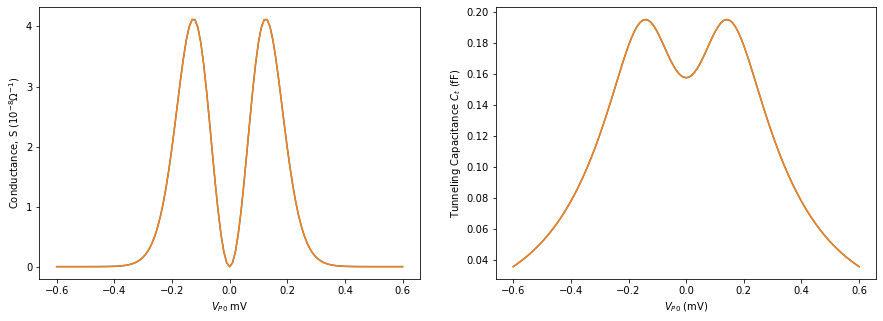

In [20]:
fitplot_s70('08', 10**8.5, 0.63, 11.28/100, 10**5.7, 0, 0.416)
# 0.06000 39.13429156850518
# 1.1838294768726663

In [89]:
def minimize_func(sym,U):
    result_s7 = minimize(total_set_weight_s7, (8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 0.5, 10.0, 6.0),args=(sym,U),method = 'trust-constr')
    return_set = [result_s7.success]
    if result_s7.success:
        return_set.append(result_s7.fun)
        return_set.append(result_s7.x)
    return return_set


In [22]:
def minimize_func_bh(sym,U):
#     inital_x = (7.2,  6.5,  6.9,  7.4,  7.4, 7.8,  8.7,  9.1,  9.6,  9.0, 8.9,  0.63, 11.28,  5.7)
    inital_x = (0.63, 11.28,  5.7)

    result_sh = basinhopping(total_set_weight_s8, inital_x,
                      niter=30, minimizer_kwargs={'args':(sym,U),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [U, result_sh.lowest_optimization_result.success]
    if result_sh.lowest_optimization_result.success:
        return_set.append(result_sh.lowest_optimization_result.fun)
        return_set.append(result_sh.lowest_optimization_result.x)
    return return_set


In [38]:
%%time
%%notify
def result_qcaps(sym,Uvals):
    result = []
    for Uval in Uvals:
        print(Uval)
        return_set = minimize_func_bh(sym,Uval)
        print(return_set)
        result.append(return_set)
    return result

result_qcaps(0,Uset)
# 202111242000 (a)
# 0.416
# [0.416, True, 34.24805655106603, array([0.606714  , 6.71279589, 6.47428428])]

0.166


C:\Users\rupes\miniconda3\envs\bourne\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[0.166, True, 119.6843145583478, array([ 0.44104332,  0.96575318, 67.44565314])]
0.249
[0.249, True, 84.39090212373527, array([-0.50783078,  2.69477416, 23.87345095])]
0.333
[0.333, True, 53.40193434066389, array([ 0.55471359,  4.02972946, 13.89454108])]
0.416
[0.416, True, 46.080487424876054, array([0.60666667, 6.6579446 , 6.53891787])]
0.5
[0.5, True, 58.644143133502446, array([0.62786634, 9.49483278, 2.9819976 ])]
0.666
[0.666, True, 143.0557685429889, array([ 0.85800514, 27.09893041,  1.5101043 ])]
1.0
[1.0, True, 329.790306126655, array([ 2.25      ,  1.37202755, 74.74441039])]


[[0.166,
  True,
  119.6843145583478,
  array([ 0.44104332,  0.96575318, 67.44565314])],
 [0.249,
  True,
  84.39090212373527,
  array([-0.50783078,  2.69477416, 23.87345095])],
 [0.333,
  True,
  53.40193434066389,
  array([ 0.55471359,  4.02972946, 13.89454108])],
 [0.416,
  True,
  46.080487424876054,
  array([0.60666667, 6.6579446 , 6.53891787])],
 [0.5, True, 58.644143133502446, array([0.62786634, 9.49483278, 2.9819976 ])],
 [0.666,
  True,
  143.0557685429889,
  array([ 0.85800514, 27.09893041,  1.5101043 ])],
 [1.0, True, 329.790306126655, array([ 2.25      ,  1.37202755, 74.74441039])]]

<IPython.core.display.Javascript object>

Wall time: 28min 36s


In [23]:
def minimize_func_bhb(sym,U):
    gvals = minimize_funch(sym,U)[3]
#     inital_x = (7.2,  6.5,  6.9,  7.4,  7.4, 7.8,  8.7,  9.1,  9.6,  9.0, 8.9,  0.63, 11.28,  5.7)
    inital_x = (7.2,  6.5,  6.9,  7.4,  7.4, 7.8,  8.7,  9.1,  9.6,  9.0, 8.9)

    result_sh = basinhopping(total_set_weight_s8b, inital_x,
                      niter=30, minimizer_kwargs={'args':(sym,U,gvals),"method": 'trust-constr'})#, T=10, stepsize=2)
    return_set = [U, result_sh.lowest_optimization_result.success]
    if result_sh.lowest_optimization_result.success:
        return_set.append(result_sh.lowest_optimization_result.fun)
        return_set.append(np.concatenate((result_sh.lowest_optimization_result.x, gvals)))
    return return_set


In [46]:
%%time
%%notify
def result_all(sym,Uvals):
    result = []
    for Uval in Uvals:
        print(Uval)
        return_set = minimize_func_bhb(1,Uval)
        print(return_set)
        result.append(return_set)
    return result

# 0.166
# [0.166, True, 895.9201592783359, array([ 5.87311399,  5.28795733,  5.87075676,  6.55148993,  7.03035515,
#         7.4645692 ,  8.32113824,  9.90382077, 10.08828601,  9.82979711,
#         8.62519232, -0.44930584,  2.4083363 , 26.17934728])]
# 0.249
# [0.249, True, 826.8521960604096, array([ 5.94379646,  5.41088251,  5.89370674,  6.62102714,  7.05929851,
#         7.37972342,  8.23253304,  9.97133751, 10.09175315,  9.85698341,
#         9.37386909, -0.50783077,  2.6947741 , 23.87345116])]
# 0.333
# [0.333, True, 728.2320271168174, array([ 6.12301421,  5.77438605,  6.08334917,  6.65515388,  7.07437847,
#         7.43425771,  8.05379744,  8.71716567, 10.11883179,  9.8642971 ,
#         9.4541095 ,  0.55471359,  4.02972942, 13.89454126])]
# 0.416
# [0.416, True, 578.8062748310241, array([ 6.29855196,  6.02753132,  6.26805692,  6.64071572,  7.27287154,
#         7.64467092,  8.18409382,  9.91159844,  9.9754291 ,  9.76438009,
#         8.78248249, -0.60666666,  6.65771243,  6.53909797])]
# 0.5
# [0.5, True, 409.9172342621471, array([6.59467612, 6.36033888, 6.59134182, 6.9828754 , 7.41962363,
#        7.86730832, 8.38967771, 9.74408958, 9.64464597, 9.28423603,
#        8.92408543, 0.62786632, 9.4948336 , 2.98199734])]
# 0.666
# [0.666, True, 509.72410407864146, array([ 6.79354948,  6.59502427,  6.88532425,  7.2278724 ,  7.37702606,
#         7.78869742,  8.42849766,  8.89878465,  8.61415408,  8.67023825,
#         9.25351736,  0.85800514, 27.09893075,  1.51010428])]
# 1.0
# [1.0, True, 1339.3974391212926, array([ 6.11331577,  5.99491603,  5.94734172,  6.018167  ,  5.87698731,
#         7.69608467,  5.4542443 ,  7.76163084, 11.60980462,  6.92371345,
#         4.88679503,  2.25000001,  1.86906322, 54.76642108])]
# Wall time: 1h 7min 19s


# 202111250251 Double step fits (Note: order of parameters is changed to alpha,T,fac,g0.....)
# # 0.166
# # [0.166, True, 1024.1900873206337, array([-0.44271548,  1.02375688, 63.59147538,  5.72836035,  4.97534237,
# #         7.57588495,  7.50614741,  7.0004466 ,  7.3584528 ,  8.17408166,
# #        10.04280918, 10.37127958, 10.01844442,  9.36816469])]
# # 0.249
# # [0.249, True, 823.2001542985782, array([ 0.51071352,  2.78747785, 23.08196703,  5.94477356,  5.45498628,
# #         5.95593287,  6.67153401,  7.07480956,  7.40386797,  8.24411107,
# #         9.91871674, 10.15312072,  9.85235203,  9.38212177])]
# # 0.333
# # [0.333, True, 715.6518862124777, array([-0.55593986,  4.10817418, 13.62572655,  6.16473557,  5.76158843,
# #         6.15346858,  6.70376059,  7.099539  ,  7.46058844,  8.0736116 ,
# #         9.92323624, 10.15321955,  9.86274723,  9.4699466 ])]
# # 0.416
# # [0.416, True, 563.587055623362, array([0.60671399, 6.71279595, 6.47428421, 6.32419803, 6.07149328,
# #        6.34944482, 6.70589388, 7.29535861, 7.67447357, 8.19618939,
# #        9.90037509, 9.98938324, 9.74591571, 8.78219668])]
# # 0.5
# # [0.5, True, 370.6848201543142, array([ 0.62883735,  9.54406693,  2.95921726,  6.63740725,  6.37742705,
# #         6.67052414,  6.99657007,  7.4667443 ,  7.92434656,  8.42851807,
# #         8.8447269 ,  9.91139593,  9.32254451, 10.17980367])]
# # 0.666
# # [0.666, True, 445.6069049345914, array([ 0.85706995, 27.13809325,  1.50336598,  6.99403314,  6.64289131,
# #         6.92296939,  7.24092952,  7.41150404,  7.7694994 ,  8.39444849,
# #         8.81332068,  8.65968927,  8.87596358,  8.96633136])]
# # 1.0
# # [1.0, True, 1356.5263055235898, array([ 2.25925928,  2.03529535, 50.57131043,  5.02729554,  6.56370585,
# #         6.57891556,  5.01714448,  6.51073403,  6.84680072,  8.19278905,
# #         7.81151643,  7.96792761,  6.95293245,  4.90738021])]
# # Wall time: 44min 41s

# 202111242195 (a)
# # 0.416
# # [0.416, True, 563.6635987376465, array([6.32419801, 6.07149328, 6.3494448 , 6.70589384, 7.29535864,
# #        7.67447353, 8.19618938, 9.73955757, 9.98938325, 9.74591575,
# #        9.92538975])]
# # Wall time: 5min 16s

0.166


C:\Users\rupes\miniconda3\envs\bourne\lib\site-packages\scipy\optimize\_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


[0.166, True, 895.9201592783359, array([ 5.87311399,  5.28795733,  5.87075676,  6.55148993,  7.03035515,
        7.4645692 ,  8.32113824,  9.90382077, 10.08828601,  9.82979711,
        8.62519232, -0.44930584,  2.4083363 , 26.17934728])]
0.249
[0.249, True, 826.8521960604096, array([ 5.94379646,  5.41088251,  5.89370674,  6.62102714,  7.05929851,
        7.37972342,  8.23253304,  9.97133751, 10.09175315,  9.85698341,
        9.37386909, -0.50783077,  2.6947741 , 23.87345116])]
0.333
[0.333, True, 728.2320271168174, array([ 6.12301421,  5.77438605,  6.08334917,  6.65515388,  7.07437847,
        7.43425771,  8.05379744,  8.71716567, 10.11883179,  9.8642971 ,
        9.4541095 ,  0.55471359,  4.02972942, 13.89454126])]
0.416
[0.416, True, 578.8062748310241, array([ 6.29855196,  6.02753132,  6.26805692,  6.64071572,  7.27287154,
        7.64467092,  8.18409382,  9.91159844,  9.9754291 ,  9.76438009,
        8.78248249, -0.60666666,  6.65771243,  6.53909797])]
0.5
[0.5, True, 409.9172342621

<IPython.core.display.Javascript object>

Wall time: 1h 7min 19s


In [ ]:
# 0.166
# [0.166, True, 895.9201592783359, array([ 5.87311399,  5.28795733,  5.87075676,  6.55148993,  7.03035515,
#         7.4645692 ,  8.32113824,  9.90382077, 10.08828601,  9.82979711,
#         8.62519232, -0.44930584,  2.4083363 , 26.17934728])]
# 0.249
# [0.249, True, 826.8521960604096, array([ 5.94379646,  5.41088251,  5.89370674,  6.62102714,  7.05929851,
#         7.37972342,  8.23253304,  9.97133751, 10.09175315,  9.85698341,
#         9.37386909, -0.50783077,  2.6947741 , 23.87345116])]
# 0.333
# [0.333, True, 728.2320271168174, array([ 6.12301421,  5.77438605,  6.08334917,  6.65515388,  7.07437847,
#         7.43425771,  8.05379744,  8.71716567, 10.11883179,  9.8642971 ,
#         9.4541095 ,  0.55471359,  4.02972942, 13.89454126])]
# 0.416
# [0.416, True, 578.8062748310241, array([ 6.29855196,  6.02753132,  6.26805692,  6.64071572,  7.27287154,
#         7.64467092,  8.18409382,  9.91159844,  9.9754291 ,  9.76438009,
#         8.78248249, -0.60666666,  6.65771243,  6.53909797])]
# 0.5
# [0.5, True, 409.9172342621471, array([6.59467612, 6.36033888, 6.59134182, 6.9828754 , 7.41962363,
#        7.86730832, 8.38967771, 9.74408958, 9.64464597, 9.28423603,
#        8.92408543, 0.62786632, 9.4948336 , 2.98199734])]
# 0.666
# [0.666, True, 509.72410407864146, array([ 6.79354948,  6.59502427,  6.88532425,  7.2278724 ,  7.37702606,
#         7.78869742,  8.42849766,  8.89878465,  8.61415408,  8.67023825,
#         9.25351736,  0.85800514, 27.09893075,  1.51010428])]
# 1.0
# [1.0, True, 1339.3974391212926, array([ 6.11331577,  5.99491603,  5.94734172,  6.018167  ,  5.87698731,
#         7.69608467,  5.4542443 ,  7.76163084, 11.60980462,  6.92371345,
#         4.88679503,  2.25000001,  1.86906322, 54.76642108])]

In [52]:
min_idx = np.argmin([bigreshvals[2] for bigreshvals in bigreshb])
print('U =',bigreshb[min_idx][0])
print('TW =',total_set_weight_s8b(bigreshb[min_idx][3][:3],0,Uset[min_idx], bigreshb[min_idx][3][-3:]))
print('Optvalues :',bigreshb[min_idx][3])

U = 0.5
TW = 409.9172342621471
Optvalues : [6.59467612 6.36033888 6.59134182 6.9828754  7.41962363 7.86730832
 8.38967771 9.74408958 9.64464597 9.28423603 8.92408543 0.62786632
 9.4948336  2.98199734]


In [24]:
def gridplotfit_v5(res_list,sym,U,save=False):
    plt.close()
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0] for idx in range(len(dset_list))]
    scale = 5
    fig, axes = plt.subplots(7,11,figsize=(12*scale,7*scale))

    for gamma, dset,g0fac,axis1,axis2,axis3,axis4,axis5,axis6,axis7 in zip(allweightset,dset_list,g0set,*axes):
        expV, expC, expIR = expvals(dset, sym)
        QuantC,theoC, theoIR = fitting_s8(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        
        axis1.text(0.35,1.1,f'$log_{{10}} (\\Gamma^0 / Hz) = {g0fac:.3f}$',transform=axis1.transAxes)
        axis1.plot(expV, expC,label=f'data set = {dset}')
        axis1.plot(expV, QuantC,label=f'$\Gamma_t = ${gamma}')
        axis1.legend()
        axis1.set_ylim(0.0,None)
        
#         axis2.text(0.35,1.1,f'$log_{{10}} (\\Gamma^0 / Hz) = {g0fac:.3f}$',transform=axis1.transAxes)
        axis2.plot(expV, expC,label=f'data set = {dset}')
        axis2.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis2.legend()
        axis2.set_ylim(0.0,None)
        
        axis3.plot(expV, expIR,label=f'data set = {dset}')
        axis3.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
        axis3.legend()
#         axis1.set_ylim(0.0,None)
        
        v0 = expV*alpha
        nu = (1 - (v0/U))
        op1 = optical_func(U,gamma)
        s_mg = np.interp(nu, op1[:,0], op1[:,1])
        axis4.plot(expV, s_mg,label=f'$\Gamma_t = ${gamma}')
#         axis2.legend()
        axis4.set_ylim(0.0,2.05)
        
        n1 = n1_func(U,gamma)
        n2 = n2_func(U,gamma)
        n_g = np.interp(nu, n1[:,0], n1[:,1])
        n_e = np.interp(nu, n2[:,0], n2[:,1])

        axis5.plot(expV, n_g,label=f'$n_g$')
        axis5.plot(expV, n_e,label=f'$n_e$')
        axis5.legend()
        axis5.set_ylim(0.0,2.1)
        
        C_tot, _ = fitting_s7(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
        C_qn = fitting_s3(gamma,alpha,T/100,10**fac,expV,U=U)
        C_q0 = fitting_s2(gamma,alpha,T/100,10**fac,expV,U=U)
        
        P0g = p0(s_mg*Delta, T/100, 10**fac)
        axis6.plot(expV,P0g,label=f'$\Gamma_t = ${gamma}')
        axis6.legend()
        
        axis7.plot(expV,C_tot,'k',label=r'$C_{total}$')
        axis7.plot(expV,C_q0,'--',label=r'$C_{q,g}$')
        axis7.plot(expV,C_qn - C_q0,'--',label=r'$C_{q,e}$')
        axis7.plot(expV,C_tot - C_qn,'--',label=r'$C_t$')
        axis7.legend()
        axis7.set_ylim(0.0,None)

    axes[0][0].set_ylabel(r'Quantum Capacitance, $C_Q$ (fF)',fontsize=15)
    axes[1][0].set_ylabel(r'Total Capacitance, C (fF) {$C_Q + C_t$}',fontsize=15)
    axes[2][0].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    axes[3][0].set_ylabel(r'Shiba mini-gap, $\delta / \Delta $',fontsize=15)
    axes[4][0].set_ylabel(r'Occupation, $n$',fontsize=15)
    axes[5][0].set_ylabel(r'P_{g,0}',fontsize=15)
    axes[6][0].set_ylabel('Capacitance, C (fF)',fontsize=15)
    axes[6][5].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
         
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {U:.3f} meV $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if not sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Not Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if save:
        if sym:
            plt.savefig(f"2D_grid_sym_S8_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"2D_grid_Nsym_S8_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
      

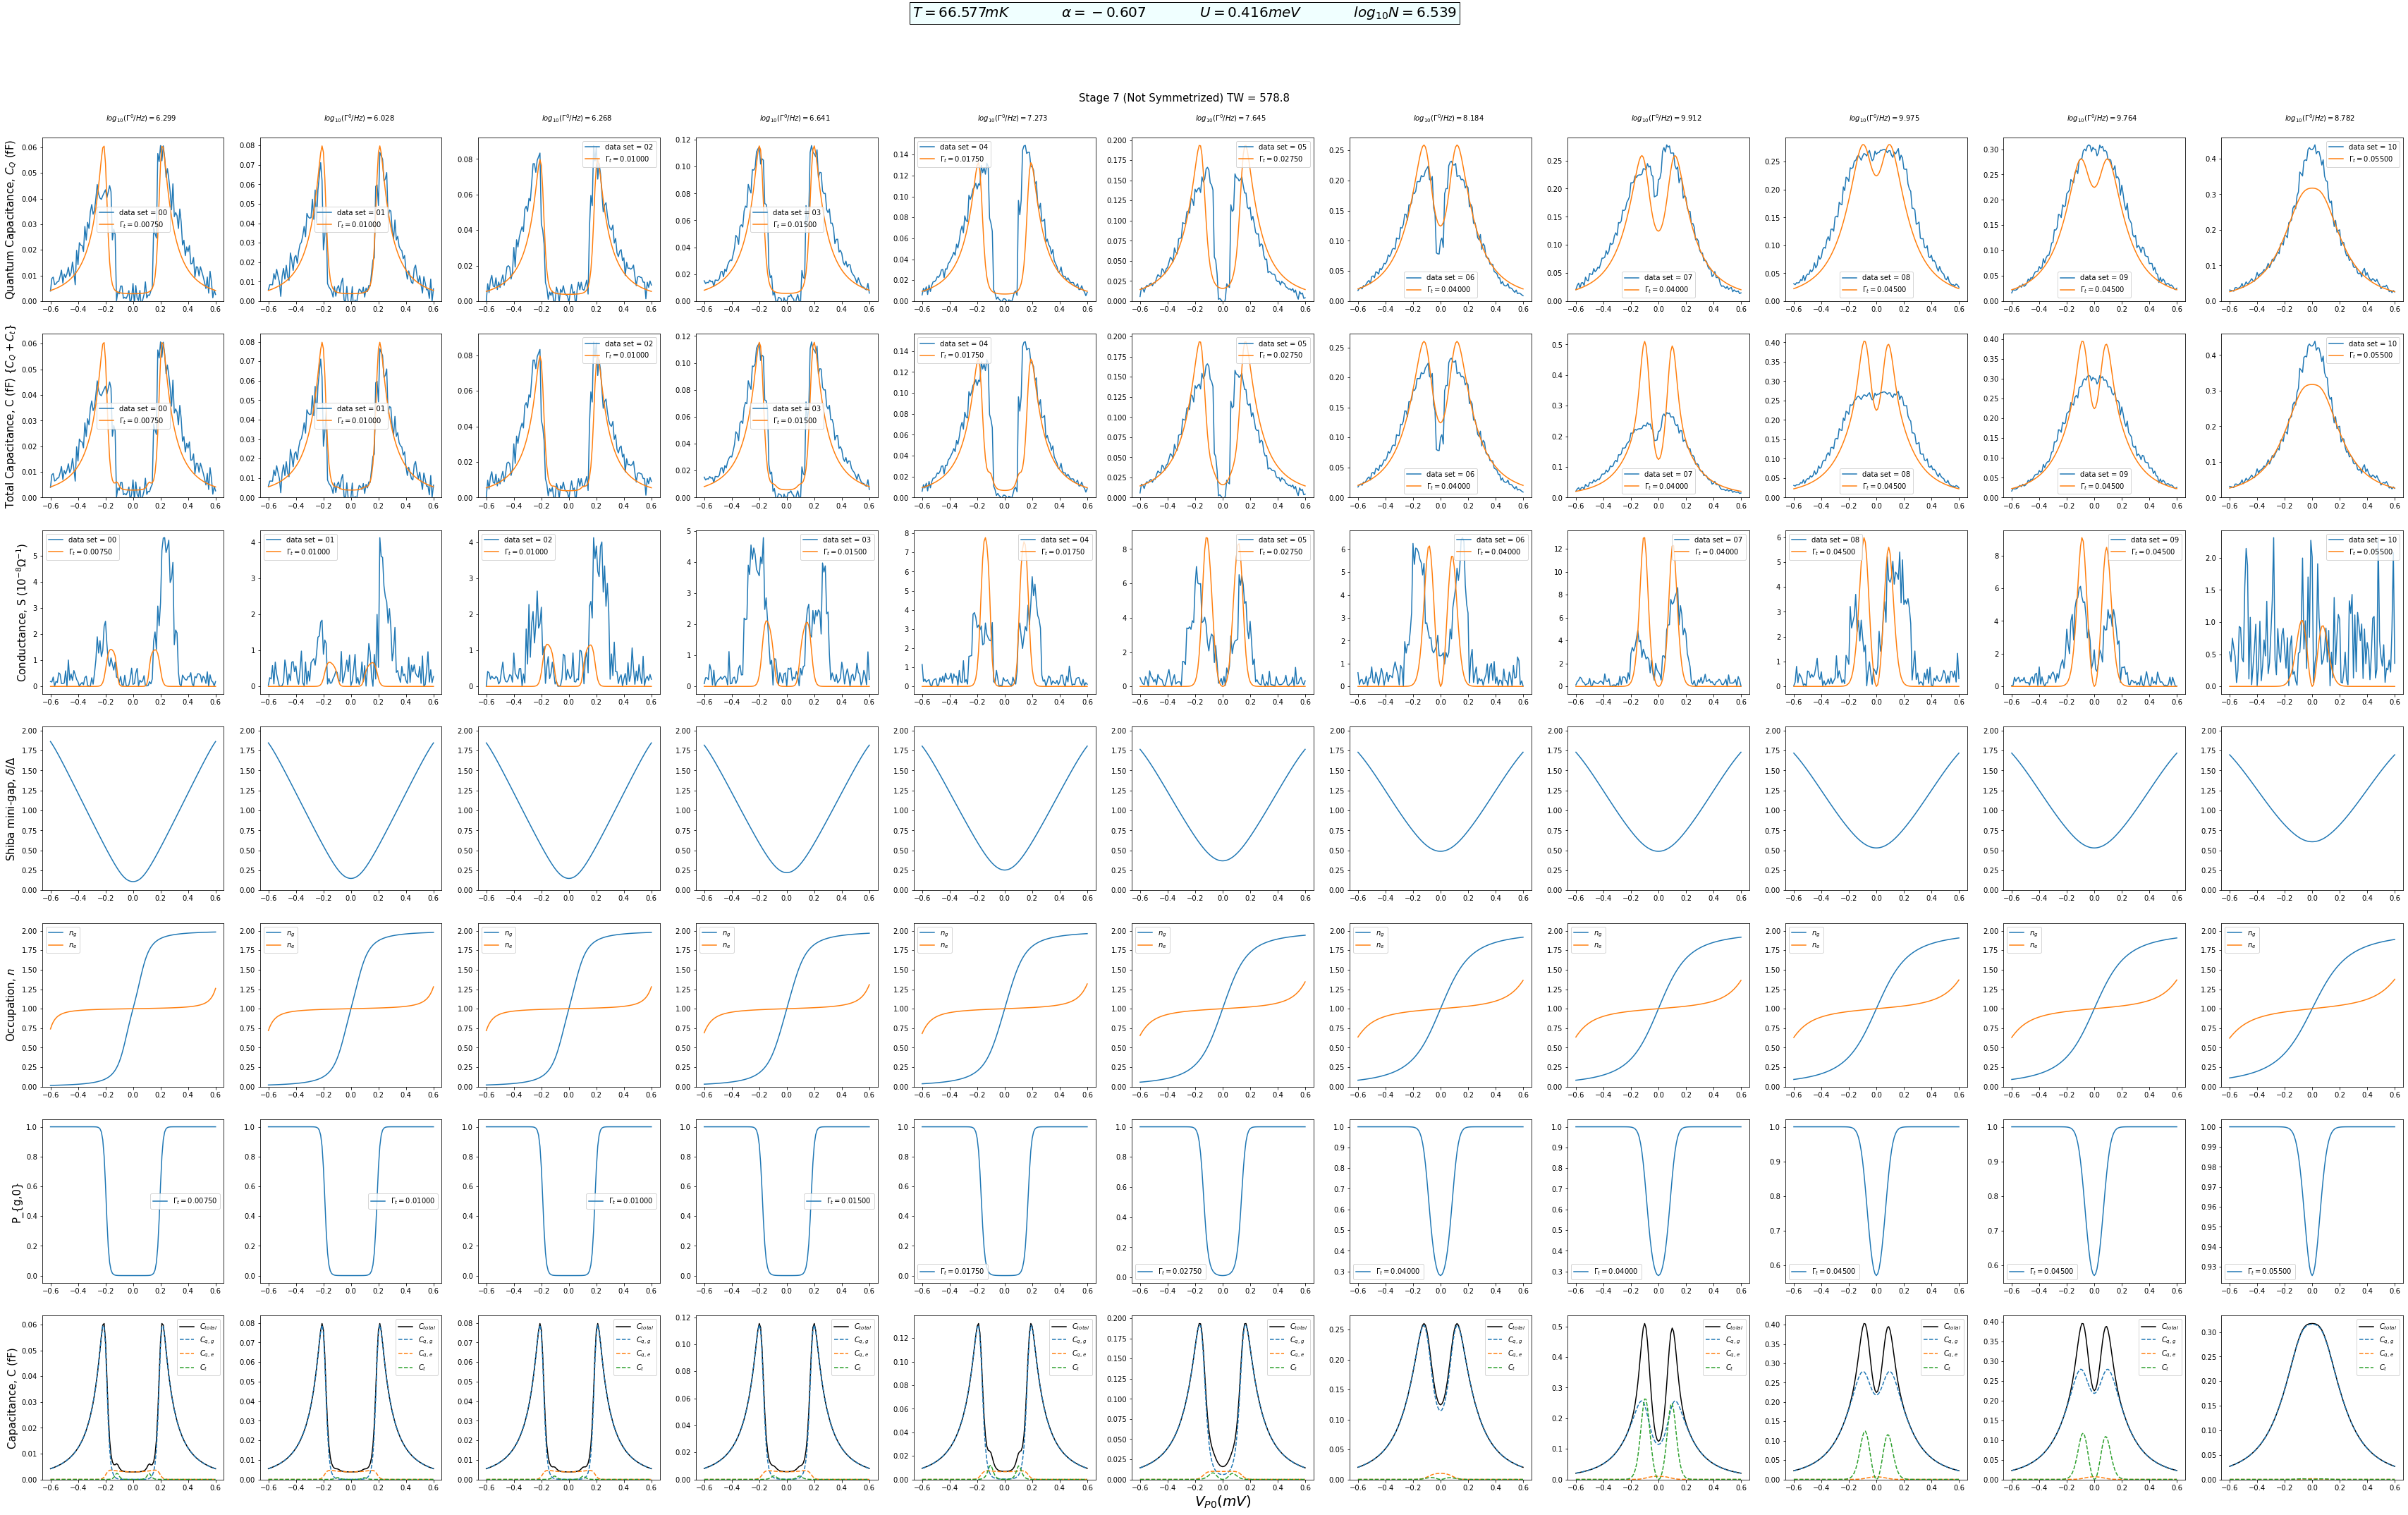

In [67]:
gridplotfit_v5(bigreshb[min_idx-1][3],0,bigreshb[min_idx-1][0],True)

In [78]:
def linlog(res_list,sym,U,save=False):
    plt.close()
    fig, axis = plt.subplots(1,1,figsize=(7,5))
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    allweightset = [float(total_weight_s7(U,dset_list2[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0]) for idx in range(len(dset_list2))]
    g0set = np.array(g0set)
    axis.scatter(allweightset,np.log10(10**g0set),s=10)
    axis.set_xlabel('$\Gamma_t$ (meV)',fontsize=13)
    axis.set_ylabel('$\log_{10}(\Gamma_0 / Hz)$',fontsize=13)
    axis.set_title('$log(\Gamma_0 / Hz)$ vs $\Gamma_t$',fontsize=13)
    parameter_string = f"$T = {T*10:.3f} mK $\
                $\\alpha        = {alpha:.3f} $\
                $U       = {U:.3f} meV$\
                $log_{{10}} N   = {fac:.3f}$"

    fig.text(
            0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
            bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
    
    if save:
        if sym:
            plt.savefig(f"logG0 vs Gt_s8_Sym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.svg", format='svg')
            plt.savefig(f"logG0 vs Gt_s8_Sym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"logG0 vs Gt_s8_NotSym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.svg", format='svg')
            plt.savefig(f"logG0 vs Gt_s8_NotSym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')


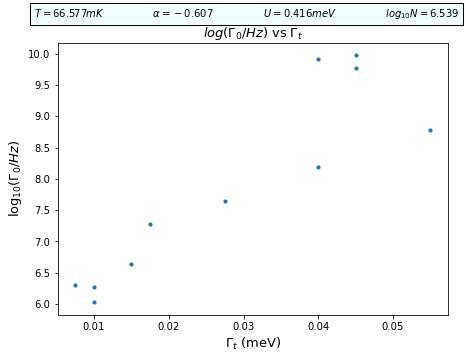

In [80]:
linlog(bigreshb[min_idx-1][3],0,bigreshb[min_idx-1][0],True)

In [84]:
from scipy.stats import linregress


In [85]:
def loglog(res_list,sym,U,save=False):
    plt.close()
    fig, axis = plt.subplots(1,1,figsize=(7,5))
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    allweightset = [float(total_weight_s7(U,dset_list2[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0]) for idx in range(len(dset_list2))]
    g0set = np.array(g0set)
    slope, intercept, _, _, _ = linregress(np.log10(allweightset), np.log10(10**g0set))
    
    axis.scatter(np.log10(allweightset),np.log10(10**g0set),s=10)
    gammat_range = np.log10(np.linspace(np.min(allweightset),np.max(allweightset),100))
    axis.plot(gammat_range,slope*gammat_range + intercept,'k')
    axis.text(0.2,0.8,f'Slope = {slope:.3f}\nIntercept = {intercept:.3f}',transform=axis.transAxes,fontsize=15)
    axis.set_xlabel('$\log_{10}(\Gamma_t / meV)$',fontsize=13)
    axis.set_ylabel('$\log_{10}(\Gamma_0 / Hz)$',fontsize=13)
    axis.set_title('$\log_{10}(\Gamma_0 / Hz)$ vs $\log_{10}(\Gamma_t / meV)$',fontsize=13,y=0.985)
    parameter_string = f"$T = {T*10:.3f} mK $\
                $\\alpha        = {alpha:.3f} $\
                $U       = {U:.3f} meV$\
                $log_{{10}} N   = {fac:.3f}$"

    fig.text(
            0.5, 0.96, parameter_string, ha='center', va='center', wrap=False,
            bbox=dict(ec='black', alpha=1, color='azure'), fontsize=10)
   
    if save:
        if sym:
            plt.savefig(f"logG0 vs logGt_s8_Sym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.svg", format='svg')
            plt.savefig(f"logG0 vs logGt_s8_Sym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"logG0 vs logGt_s8_NotSym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.svg", format='svg')
            plt.savefig(f"logG0 vs logGt_s8_NotSym_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')


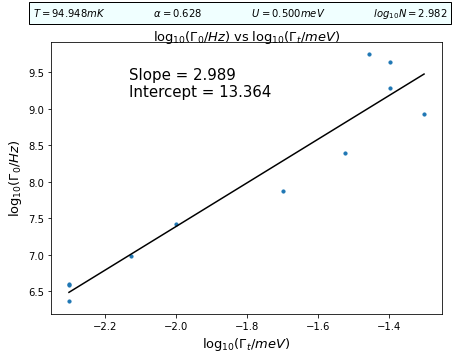

In [87]:
loglog(bigreshb[min_idx][3],0,bigreshb[min_idx][0],True)

In [39]:
result = np.array([ 6.29855196,  6.02753132,  6.26805692,  6.64071572,  7.27287154,
        7.64467092,  8.18409382,  9.91159844,  9.9754291 ,  9.76438009,
        8.78248249, -0.60666666,  6.65771243,  6.53909797])

In [ ]:
def update_plot_fit_v5(res_list,sym,U,save=False):
    plt.close()
    *_,alpha,T,fac = res_list
    *g0set, _, _, _ = res_list
    dset_list = dset_list2
    allweightset = [total_weight_s7(U,dset_list[idx],10**g0set[idx],alpha,T/100,10**fac,sym)[0] for idx in range(len(dset_list))]
    scale = 5
    fig, axes = plt.subplots(2,5,figsize=(12*scale,7*scale))
    
    axes = axes.flatten()
    
    for gamma, dset,g0fac,axis in zip(allweightset,dset_list,g0set,axes):
        expV, expC, expIR = expvals(dset, sym)
        QuantC,theoC, theoIR = fitting_s8(U,gamma,10**g0fac,alpha,T/100,10**fac,expV)
    
        axis.plot(expV, expC,label=f'data set = {dset}')
        axis.plot(expV, theoC,label=f'$\Gamma_t = ${gamma}')
        axis.legend()
        axis.set_ylim(0.0,None)
        
#         axis3.plot(expV, expIR,label=f'data set = {dset}')
#         axis3.plot(expV, theoIR,label=f'$\Gamma_t = ${gamma}')
#         axis3.legend()
    
    axes[0].set_ylabel(r'Total Capacitance, C (fF) {$C_Q + C_t$}',fontsize=15)
    axes[6].set_ylabel(r'Conductance, S ($10^{-8} \Omega^{-1}$)',fontsize=15)
    
    axes[7].set_xlabel(r'$V_{P0} (mV) $',fontsize=20)
    
         
    parameter_string = f"$T = {T*10:.3f} mK $\
            $\\alpha        = {alpha:.3f} $\
            $U       = {U:.3f} meV $\
            $log_{{10}} N   = {fac:.3f}$"
    
    fig.text(
        0.5, 0.95, parameter_string, ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=1, color='azure'), fontsize=20)
    if sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    if not sym:
        fig.text(
        0.5, 0.902, f"Stage 7 (Not Symmetrized) TW = {total_set_weight_s7(res_list,sym,U):.1f}", ha='center', va='center', wrap=False,
        bbox=dict(ec='black', alpha=0, color='azure'), fontsize=15)
    
    if save:
        if sym:
            plt.savefig(f"Update_sym_S8_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
        else:
            plt.savefig(f"Update_Nsym_S8_U{U}_log10_Go-{np.mean(res_list[:-3]):.2f}_{[f'{member[0]}{member[1]:.2f}_' for member in zip(['alpha-','mK_T-','log10_N-'],res_list[-3:])]}.pdf", format='pdf')
      

In [ ]:
min_idx = 2
trial_vals = np.arange(1,10,0.1)
weiths = [total_set_weight_s7((*bigresh[min_idx][2][:-1],trial_valsss),1,Uset[min_idx]) for trial_valsss in trial_vals]
plt.plot(trial_vals,weiths)


In [ ]:
# # RENAME CODE

# For U Dirs
# # # for file_names in os.listdir(dirpath):
# # #     if file_names[0:2]=='U=':
# # #         os.rename(dirpath+file_names,dirpath+f'{file_names[:4]}{int(file_names[4:]):<03d}')

# For Gt dirs
# # # dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # # Uset = tuple(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # # Gamma_dict = list([list([file_names.split('=')[-1]
# # #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# # #                          if file_names[0:2]=='U=']) for Uvals in Uset])
# # # for idx1, usets in enumerate(Gamma_dict):
# # #     for idx2, gammavals in enumerate(usets):
# # #         filepath = f"U={Uset[idx1]}\\U={Uset[idx1]}_Gamma="
# # #         oldpath = dirpath+filepath+gammavals
# # #         newpath = dirpath+filepath + f'{gammavals[:-1]}{int(gammavals[-1]):<010d}'[:7]
# # #         os.rename(oldpath,newpath)


In [ ]:
# dirpath = f"f1web.ijs.si\\~zitko\\data\\chi\\"
# # Uset = list(np.sort([file_names[2:] for file_names in os.listdir(dirpath) if file_names[0:2]=='U=']))

# # Gamma_dict = {} #Dict.empty(key_type = types.unicode_type, value_type = types.float64[:])
# optical1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n1_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])
# # n2_data = Dict.empty(key_type = types.unicode_type, value_type = types.float64[:,:,:])

# # for Uvals in Uset:
# #     Gamma_dict(Uvals) = np.array([file_names.split('=')[-1]
# #                          for file_names in os.listdir(dirpath+f'U={Uvals}')
# #                          if file_names[0:2]=='U='])
    
# # Gamma_dict['1.0'].remove('0.005') # this data file is incomplete

# for Uvals in Uset:
#     optical1_data[Uvals] = np.array(
#         [
#             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
#             for gammaa in Gamma_dict_func(Uvals)
#         ]
#     )
# #     n1_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )
# #     n2_data[Uvals] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict[Uvals]
# #         ]
# #     )

# # n1_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}
# # n2_data       = {Uvals:np.array([np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400] 
# #                                  for gammaa in Gamma_dict[Uvals]]) 
# #                  for Uvals in Uset}

In [ ]:
# 
# # Udtype = np.dtype([(f'U{Uvals}', np.float64, (len(Gamma_dict_func(Uvals)),400)) for Uvals in Uset])
# # optical1_data = np.zeros(2,dtype=Udtype)
# # n1_data = np.zeros(2,dtype=Udtype)
# # n2_data = np.zeros(2,dtype=Udtype)

# # for Uvals in Uset:
# #     optical1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     optical1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\optical1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n1_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n1_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n1.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]
    
# #     n2_data[f'U{Uvals}'][0,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,0]
# #     n2_data[f'U{Uvals}'][1,:,:] = np.array(
# #         [
# #             np.genfromtxt(f"{dirpath}U={Uvals}\\U={Uvals}_Gamma={gammaa}\\n2.dat")[:400]
# #             for gammaa in Gamma_dict_func(Uvals)
# #         ])[:,:,1]